In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter #for counting elements in a histogram
from scipy.stats.kde import gaussian_kde
import statsmodels.api as sm
from statsmodels.nonparametric.bandwidths import bw_silverman, bw_scott, select_bandwidth
from IPython.display import display
from scipy.integrate import quad
from scipy.stats import norm, entropy
from scipy.stats import rayleigh
from scipy.stats import binom
import seaborn as sns
import scipy.stats as ss
from sklearn.neighbors import KernelDensity

## Estimation of Shannon entropy

When we want to calculate for a data set, for which we do not know the analytical formula,  we can no longer **calculate** the entropy, but only **estimate** entropy. 
The first step then, is  to estimate a pdf, as described above

<b> To explore the concepts in this notebook: </b>:
* compare the entropy values of the estimated set with the analytical value of the entropy in the cell output;
* run the cell a couple of time and see how the estimate changes as a function of the random number generated;
* change the number of points availabe for estimating the pdf, by changing the value of the variable ```samples``` and observe the difference in entropy



In [3]:
def entropy_estimate_true(x, m, s):
    """  
    Estimate Shannon Entropy of the dataset x, using
    the analytical formula of the true distribution is known
    
    x = input data
    m = true mean 
    s = true standard deviation 
    
    returns H(X) - estimate Shannon Entropy
    """
    p_x=ss.norm.pdf(x,m,s)
    return -np.mean(np.where(p_x != 0, np.log2(p_x), 0))

def entropy_estimate_crude(x):
    """ 
    Estimate the Shannon Entropy for dataset x
    using estimated mean and standard deviation
          
    x = input data
    
    returns H(X) - estimate Shannon Entropy
    """
    (m,s)=[np.mean(x),np.std(x)]
    p_x=ss.norm.pdf(x,m,s)
    return -np.mean(np.where(p_x != 0, np.log2(p_x), 0))
  
def entropy_estimate_kde(x, bandwidth=0.4):
    """ 
    Estimate the Shannon Entropy for dataset x
    using the KDE for density estimation
          
    x = input data
    
    returns H(X) - estimate Shannon Entropy
    """
    kde= KernelDensity(bandwidth, kernel='gaussian').fit(x[:, np.newaxis])
    p_x = np.exp(kde.score_samples(x[:, np.newaxis]))
   
    return -np.mean(np.where(p_x > 0, np.log2(p_x), 0))
   
def entropy_estimate_hist(xs_syntetic, b='auto'):
    """ 
    Estimate the Shannon Entropy for dataset x
    using the histogram method
          
    x = input data
    
    returns H(X) - estimate Shannon Entropy
    """

    ys_freq,ys_hist=np.histogram(xs_syntetic,bins=b)
    bin_size=ys_hist[1]-ys_hist[0]
    p_y=ys_freq/len(xs_syntetic)
    acc=0
    if bin_size > 0:
        for p in p_y:
            if p/bin_size > 0:
                acc += p * np.log2(p/bin_size)
    return(-acc)      
    #return -np.sum(np.where(p_y/bin_size > 0, p_y * np.log2(p_y/bin_size), 0))
    

def entropy_normal(f,m,s):
    """ 
    Calculates the Shannon Entropy for variable x, 
    when we known the formula for the probability density function 
          
    f = formula for probability density
    m = first order moment
    s = second order moment
    
    returns H(X) - Shannon Entropy
    """
    g= lambda x:f(x,m,s)
    def g_log(x):
        temp=g(x)
        if temp==0:
            return 0
        else:
            return temp*(np.log2(temp))
    i,err=quad(g_log, -np.inf,np.inf)
    return -i


m=-2 
s=2

samples=150
xs_syntetic=ss.norm.rvs(m,s,samples)
print('Entropy value =  ' +str(entropy_normal(norm.pdf,m,s)))
print('H(X) (true):    ',entropy_estimate_true(xs_syntetic, m,s))
print('H(X) (crude):   ',entropy_estimate_crude(xs_syntetic))
print('H(X) (KDE):     ',entropy_estimate_kde(xs_syntetic, bandwidth=0.4))
print('H(X) (hist):    ',entropy_estimate_hist(xs_syntetic))


Entropy value =  3.0470955851806423
H(X) (true):     3.101851507400887
H(X) (crude):    3.0985811531540732
H(X) (KDE):      3.0067320240140405
H(X) (hist):     2.9984540194989875


## Precision of estimation

In this section we explore the precision of the estimation as a function of the number of samples we have available.
We expect that the more points we have in the dataset, the closer the estimated values will be to the true value. The raeson being that estimated mean and standard deviation will be to the true mean and standard deviation. 

<b> To explore the concepts in this section: </b>:
* change the parameters of the probability density, by changing the values of ```m```, the mean, and ```s```  standard density values;
* run the cell a couple of time and see how the estimate changes as a function of the generated dataset;
* consider the following questions: Are our assumptions correct? The more points we have the more precise the estimation becomes?  How does the standard deviation value influence the precision of the estimate? Which of the three estimations methods seems to perform best?



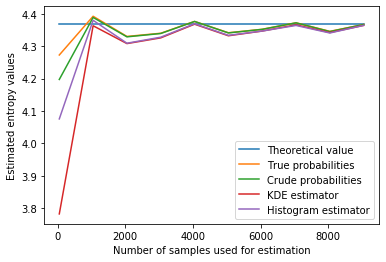

In [8]:
m=-2
s=5

min_points = 50 #the minimum points in the set to start estimation
max_points = 10000 # the maximum number of points 
step = 1000
samples = list(range(min_points,max_points,step))

hx_theory = np.zeros(len(samples))+ entropy_normal(norm.pdf,m,s)
hx_true = np.zeros(len(samples))
hx_crude = np.zeros(len(samples))
hx_kde = np.zeros(len(samples))
hx_hist = np.zeros(len(samples))

for i,value in enumerate(samples):
    #xs_syntetic=ss.norm.rvs(m,s,value, random_state=1234)
    xs_syntetic=ss.norm.rvs(m,s,value)
    hx_true[i]=entropy_estimate_true(xs_syntetic, m,s)
    hx_crude[i]=entropy_estimate_crude(xs_syntetic)
    hx_kde[i] = entropy_estimate_kde(xs_syntetic, bandwidth=0.4)
    hx_hist[i]= entropy_estimate_hist(xs_syntetic)
    


plt.plot(samples, hx_theory, label='Theoretical value')
plt.plot(samples, hx_true, label='True probabilities')
plt.plot(samples, hx_crude, label='Crude probabilities')
plt.plot(samples, hx_kde, label='KDE estimator')
plt.plot(samples, hx_hist, label='Histogram estimator')
plt.xlabel('Number of samples used for estimation')
plt.ylabel('Estimated entropy values')
plt.legend()
plt.show()